In [174]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [175]:
import numpy as np
import pandas as pd

In [176]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [177]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [178]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [179]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [180]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [181]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [182]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [183]:
# Get the column names and types of each table
inspector = inspect(engine)

measurement_columns = inspector.get_columns('measurement')
print('MEASUREMENT TABLE')
for column in measurement_columns:
    print(column["name"], column["type"])
    
print()

print('STATION TABLE')
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])

MEASUREMENT TABLE
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

STATION TABLE
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

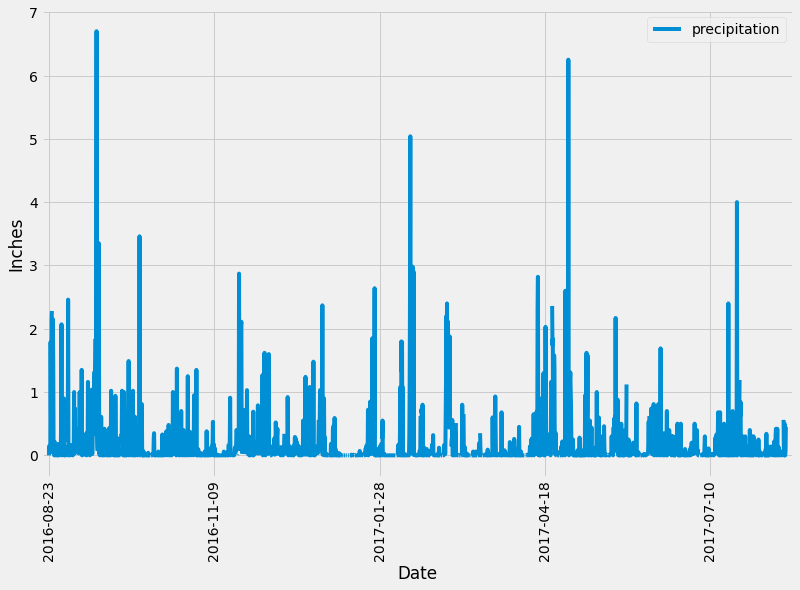

In [184]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
qry_last_row = 'SELECT date FROM measurement m ORDER BY m.id DESC LIMIT 1'
last_date = engine.execute(qry_last_row).fetchall()
last_date_point = last_date[0][0] # the last date in the data set

last_date = dt.datetime.strptime(last_date_point,'%Y-%m-%d').date()
delta = dt.timedelta(days=365)
date_one_year_ago = last_date - delta # the date one year ago

# Perform a query to retrieve the data and precipitation scores
precipitation_results = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= date_one_year_ago).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data = pd.DataFrame(precipitation_results,columns=['date','precipitation'])
precipitation_data = precipitation_data.set_index("date")

# Use Pandas Plotting with Matplotlib to plot the data
Climate_Analysis_Plot = precipitation_data.plot(use_index=True, y='precipitation', figsize=(12,8))
Climate_Analysis_Plot.set_xlabel("Date")
Climate_Analysis_Plot.set_ylabel("Inches")
plt.xticks(rotation=90)
plt.margins(x=0.01)

plt.show()

In [185]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [186]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(func.count(Station.id)).all()
print(f'the number of stations available is {number_of_stations[0][0]}.')

the number of stations available is 9.


In [187]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

query = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

stations_by_activity = pd.DataFrame(query)
stations_by_activity = most_active_stations.rename(columns={0: 'station', 1: 'station_count'})
stations_by_activity

,station,station_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [188]:
# Most active station
most_active_station = stations_by_activity.head(1)
most_active_station

,station,station_count
0,USC00519281,2772


In [189]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station_id = most_active_station['station'][0]

highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station==most_active_station_id).all()
print(f'the highest temperature for {station_id} is {highest_temp[0][0]} F')

lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station==most_active_station_id).all()
print(f'the lowest temperature for {station_id} is {lowest_temp[0][0]} F')

average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station==most_active_station_id).all()
print(f'the average temperature for {station_id} is {round(average_temp[0][0],2)} F')

the highest temperature for USC00519281 is 85.0 F
the lowest temperature for USC00519281 is 54.0 F
the average temperature for USC00519281 is 71.66 F


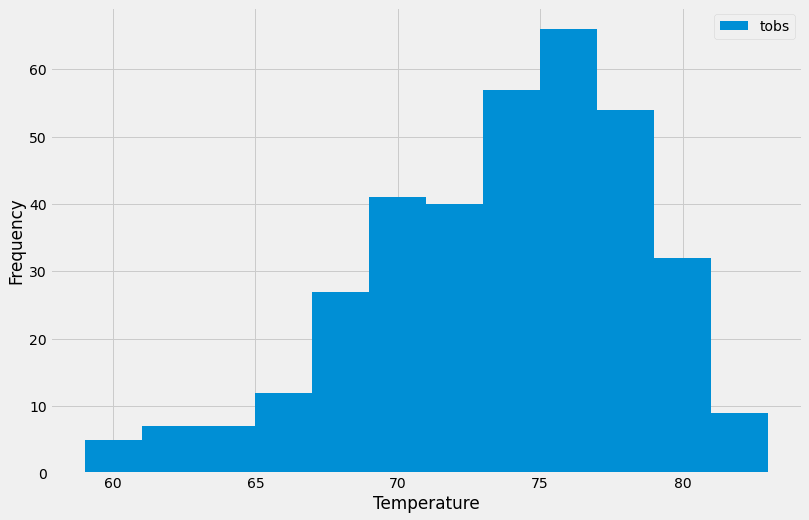

In [190]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Step 1: Find the last date mentioned for station 'USC00519281'
qry_last_row = f"SELECT date, tobs FROM measurement m WHERE m.station == '{most_active_station_id}' ORDER BY m.id DESC LIMIT 1"
last_date = engine.execute(qry_last_row).fetchall()
last_date_point = last_date[0][0] # the last date in the data set
last_date_point

# Step 2: Find the date one year ago for station 'USC00519281'
last_date = dt.datetime.strptime(last_date_point,'%Y-%m-%d').date()
delta = dt.timedelta(days=365)
date_one_year_ago = last_date - delta # the date one year ago
date_one_year_ago

# Step 3: Query the results
tobs_results = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.date >= date_one_year_ago, Measurement.station==most_active_station_id).\
order_by(Measurement.date.asc()).all()

# Step 4: Display the results in a DataFrame
df = pd.DataFrame(tobs_results,columns=['date','tobs'])
df = df.set_index('date')

# Step 5: Show the results in a histogram
temperature_histogram = df.plot.hist(bins=12,figsize=(12,8))
temperature_histogram.set_xlabel("Temperature")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
